<a href="https://colab.research.google.com/github/MichelePresti/NAS_MachineLearningDeepLearning/blob/main/NASWOT_Project8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Define Config


In [173]:
config = {}
max_uid = 15625
#@title ##Configuration Info { run: "auto" }
#configuration by param
api_loading_mode = "Lite" #@param {type: "string"} ["Lite", "Full"]
dataset = "cifar10" #@param {type:"string"} ["cifar10", "cifar100", "ImageNet16"]
run_id =  1# @param {type:"integer"}
trial =  2#@param {type:"integer"}
n_random =  10#@param {type:"integer"}
point = '2a' # @param ['2a', '2b']
imagenet_path = 'Use only if dataset=Imagenet16' #@param{type:"string"}
use_default_path = True #@param{type:"boolean"}
n_evolution = 2#@param{type: "integer"}
n_arch_distance = 2#@param{type: "integer"}
n_survivor = 1#@param{type:"integer"}
population_size = 10#@param{type:"integer"}
proxy_type = "ReLU" #@param {type: "string"} ["ReLU", "SynFlow"]
CIFAR10 = 'cifar10'
CIFAR100 = 'cifar100'
IMAGENET = 'ImageNet16'


config['score'] = 'hook_logdet'
config['nasspace'] = 'nasbench201'
config['augtype'] = 'none'
config['dataset'] = dataset
config['maxofn'] = 3
config['batch_size'] = 128
config['seed'] = 1
config['run_id'] = run_id
config['dataset_id'] = 'CIFAR10'
config['start_uid'] = 0 
config['stop_uid'] =  15000 
config['trial'] = trial
config['n_random'] = n_random
config['point'] = point
config['imagenet_path'] = '/content/drive/MyDrive/ImageNet16' if use_default_path else imagenet_path
config['n_evolution'] = n_evolution
config['n_arch_distance'] = n_arch_distance
config['n_survivor'] = n_survivor
config['population_size'] = population_size
config['proxy_type'] = proxy_type
config['api_loading_mode'] = api_loading_mode

#max 15625 stop_uid

In [174]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [175]:
%%capture
!git clone https://github.com/MichelePresti/NAS_MachineLearningDeepLearning

In [176]:
!cp -r /content/NAS_MachineLearningDeepLearning/neural_model .
!cp -r /content/NAS_MachineLearningDeepLearning/ZeroCostNas .

# Importing NasBenchAPI ✍

In [54]:
import pandas as pd

def get_arch_config_by_dataset(dataset) -> pd.DataFrame:
    """
    This function return the architectures config by dataset in a pandas dataframe.
    PARAMETERS:
       dataset= string among [cifar10, cifar100, imaginet]
    """
    if(dataset == 'cifar10'):
        df = pd.read_csv('/content/NAS_MachineLearningDeepLearning/doc/nas_bench_201__CIFAR10_config.csv', header=0)
        return df
    if(dataset == 'cifar100'):
      df = pd.read_csv('/content/NAS_MachineLearningDeepLearning/doc/nas_bench_201__CIFAR100_config.csv', header=0)
      return df
    if(dataset == 'ImageNet16'):
      df = pd.read_csv('/content/NAS_MachineLearningDeepLearning/doc/nas_bench_201__ImageNet16_config.csv', header=0)
      return df
    else: 
      print('Dataset name not valid')
      return None

def get_standard_config(csv_config: pd.DataFrame) -> dict:
    res = {}
    res['name'] = csv_config.iloc[0]['name']
    res['C'] = csv_config.iloc[0]['C']
    res['N'] = csv_config.iloc[0]['N']
    res['arch_str'] = csv_config.iloc[0]['arch_str']
    res['num_classes'] = 1
    return res

In [55]:
import pandas as pd

if config['api_loading_mode'] == 'Lite':
  searchspace = get_arch_config_by_dataset(config['dataset'])
else:
  # To be implemented the full version (Loading the NASBench201 API)
  pass

print('SearchSpace Loaded')

SearchSpace Loaded


#Import Dataset

In [56]:
##################################################
# Copyright (c) Xuanyi Dong [GitHub D-X-Y], 2019 #
##################################################
import os, sys, hashlib, torch
import numpy as np
from PIL import Image
import torch.utils.data as data

if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle


def calculate_md5(fpath, chunk_size=1024 * 1024):
    md5 = hashlib.md5()
    with open(fpath, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            md5.update(chunk)
    return md5.hexdigest()


def check_md5(fpath, md5, **kwargs):
    return md5 == calculate_md5(fpath, **kwargs)


def check_integrity(fpath, md5=None):
    if not os.path.isfile(fpath):
        return False
    if md5 is None:
        return True
    else:
        return check_md5(fpath, md5)


class ImageNet16(data.Dataset):
    # http://image-net.org/download-images
    # A Downsampled Variant of ImageNet as an Alternative to the CIFAR datasets
    # https://arxiv.org/pdf/1707.08819.pdf

    train_list = [
        ["train_data_batch_1", "27846dcaa50de8e21a7d1a35f30f0e91"],
        ["train_data_batch_2", "c7254a054e0e795c69120a5727050e3f"],
        ["train_data_batch_3", "4333d3df2e5ffb114b05d2ffc19b1e87"],
        ["train_data_batch_4", "1620cdf193304f4a92677b695d70d10f"],
        ["train_data_batch_5", "348b3c2fdbb3940c4e9e834affd3b18d"],
        ["train_data_batch_6", "6e765307c242a1b3d7d5ef9139b48945"],
        ["train_data_batch_7", "564926d8cbf8fc4818ba23d2faac7564"],
        ["train_data_batch_8", "f4755871f718ccb653440b9dd0ebac66"],
        ["train_data_batch_9", "bb6dd660c38c58552125b1a92f86b5d4"],
        ["train_data_batch_10", "8f03f34ac4b42271a294f91bf480f29b"],
    ]
    valid_list = [
        ["val_data", "3410e3017fdaefba8d5073aaa65e4bd6"],
    ]

    def __init__(self, root, train, transform, use_num_of_class_only=None):
        self.root = root
        self.transform = transform
        self.train = train  # training set or valid set
        if not self._check_integrity():
            raise RuntimeError("Dataset not found or corrupted.")

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.valid_list
        self.data = []
        self.targets = []

        # now load the picked numpy arrays
        for i, (file_name, checksum) in enumerate(downloaded_list):
            file_path = os.path.join(self.root, file_name)
            # print ('Load {:}/{:02d}-th : {:}'.format(i, len(downloaded_list), file_path))
            with open(file_path, "rb") as f:
                if sys.version_info[0] == 2:
                    entry = pickle.load(f)
                else:
                    entry = pickle.load(f, encoding="latin1")
                self.data.append(entry["data"])
                self.targets.extend(entry["labels"])
        self.data = np.vstack(self.data).reshape(-1, 3, 16, 16)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC
        if use_num_of_class_only is not None:
            assert (
                isinstance(use_num_of_class_only, int)
                and use_num_of_class_only > 0
                and use_num_of_class_only < 1000
            ), "invalid use_num_of_class_only : {:}".format(use_num_of_class_only)
            new_data, new_targets = [], []
            for I, L in zip(self.data, self.targets):
                if 1 <= L <= use_num_of_class_only:
                    new_data.append(I)
                    new_targets.append(L)
            self.data = new_data
            self.targets = new_targets

    def __repr__(self):
        return "{name}({num} images, {classes} classes)".format(
            name=self.__class__.__name__,
            num=len(self.data),
            classes=len(set(self.targets)),
        )

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index] - 1

        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.data)

    def _check_integrity(self):
        root = self.root
        for fentry in self.train_list + self.valid_list:
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, filename)
            if not check_integrity(fpath, md5):
                return False
        return True



In [57]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
import torch

def get_dataset(dataset) -> DataLoader:
    """
    This function return the dataset given its name in torch DataLoader format.
    PARAMETERS:
       dataset= string among [cifar10, cifar100, imaginet]
    """

    if dataset == 'cifar10':
        mean = [x / 255 for x in [125.3, 123.0, 113.9]]
        std = [x / 255 for x in [63.0, 62.1, 66.7]]
        lists = [transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), transforms.ToTensor(),
              transforms.Normalize(mean, std)]
        transform = transforms.Compose(lists)
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform)
        train_dt = torch.utils.data.DataLoader(trainset, batch_size=config['batch_size'],
                                                  shuffle=True, num_workers=2)
    elif dataset == 'cifar100':
        mean = [x / 255 for x in [129.3, 124.1, 112.4]]
        std = [x / 255 for x in [68.2, 65.4, 70.4]]
        lists = [transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), transforms.ToTensor(),
              transforms.Normalize(mean, std)]
        transform = transforms.Compose(lists)
        trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                                download=True, transform=transform)
        train_dt = torch.utils.data.DataLoader(trainset, batch_size=config['batch_size'],
                                                  shuffle=True, num_workers=2)
    elif dataset.startswith('ImageNet16'):
        mean = [x / 255 for x in [122.68, 116.66, 104.01]]
        std = [x / 255 for x in [63.22, 61.26, 65.09]]
        lists = [transforms.RandomHorizontalFlip(), transforms.RandomCrop(16, padding=2), transforms.ToTensor(),
                 transforms.Normalize(mean, std)]
        transform = transforms.Compose(lists)
        trainset = ImageNet16(config['imagenet_path'], True, transform, 120)
        train_dt = torch.utils.data.DataLoader(trainset, batch_size=config['batch_size'],
                                                  shuffle=True, num_workers=2)
    else:
        raise TypeError("Unknow dataset : {:}".format(dataset))

    return train_dt

In [58]:
train_dt = get_dataset(config['dataset'])

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [59]:
import pandas as pd

if config['dataset'] == 'cifar10':
  df = pd.read_csv('/content/NAS_MachineLearningDeepLearning/doc/Cifar10Result.csv')
elif config['dataset'] == 'cifar100':
  df = pd.read_csv('/content/NAS_MachineLearningDeepLearning/doc/Cifar100Result.csv')
else:
  df = pd.read_csv('/content/NAS_MachineLearningDeepLearning/doc/ImageNet16Result.csv')

try: 
  df.drop(columns=['Unnamed: 0'], inplace=True)
except:
  print("Already dropped")

acc_df = df


# NASWOT Scoring Algorithm ➗

In [60]:
import numpy as np

def get_batch_jacobian(net, x, target, device, args=None):
    net.zero_grad()
    x.requires_grad_(True)
    y, out = net(x)
    y.backward(torch.ones_like(y))
    jacob = x.grad.detach()
    return jacob, target.detach(), y.detach(), out.detach()


def hooklogdet(K, labels=None):
    s, ld = np.linalg.slogdet(K)
    return ld


def score_network(network, x, x2, target, device):
    jacobs, labels, y, out = get_batch_jacobian(network, x, target, device, config)
    network(x2.to(device))
    value = hooklogdet(network.K, target)
    return value

In [61]:
import time
import random
import pandas as pd
from neural_model.neural_model import get_cell_net

"""
NAS WOT Algorithm
"""

def naswot_search(dataset, device, population, run_id=-1) -> pd.DataFrame:
    result = {'uid': [], 'score': [], 'elapsed_time': [], 'accuracy': [], 'run_id':[]}
    for uid in population:
      net_config: pd.DataFrame = searchspace.loc[searchspace['uid'] == uid]
      net_config: dict = get_standard_config(net_config)
      network = get_cell_net(net_config)
      try:
          start = time.time()
          if 'hook_' in config['score']:

              def counting_forward_hook(module_hook, inp, out):
                  try:
                      if hasattr(module_hook, 'visited_backwards') and not module_hook.visited_backwards:
                          return
                      if isinstance(inp, tuple):
                          inp = inp[0]
                      inp = inp.view(inp.size(0), -1)
                      x = (inp > 0).float()
                      K = x @ x.t()
                      K2 = (1. - x) @ (1. - x.t())
                      if hasattr(network, 'K'):
                        network.K = network.K + K.cpu().numpy() + K2.cpu().numpy()
                      else: 
                        network.K = K.cpu().numpy() + K2.cpu().numpy()
                  except Exception as exception:
                      print(exception)
                      pass


              def counting_backward_hook(module_hook, inp, out):
                  module_hook.visited_backwards = True

              j = []
              for name, module in network.named_modules():
                  j.append(name)
                  if 'ReLU' in str(type(module)):
                      module.register_forward_hook(counting_forward_hook)
                      module.register_backward_hook(counting_backward_hook)
          network = network.to(device)
          s = []
          for j in range(config['maxofn']):
              data_iterator = iter(train_dt)
              x, target = next(data_iterator)
              x2 = torch.clone(x)
              x2 = x2.to(device)
              x, target = x.to(device), target.to(device)
              jacobs, labels, y, out = get_batch_jacobian(network, x, target, device, config)
              if 'hook_' in config['score']:
                  network(x2.to(device))
                  value = hooklogdet(network.K, target)
                  s.append(value)
              else:
                  value = hooklogdet(network.K, target)
                  s.append(value)
          acc = acc_df['valid-accuracy'].iloc[uid]
          print(f'Score (uid {uid}): {np.mean(s)}, Accuracy: {acc}')
          stop = time.time()
          result['uid'].append(uid)
          result['score'].append(np.mean(s))
          result['accuracy'].append(acc)
          result['run_id'].append(run_id)
          score = np.mean(s)
          result['elapsed_time'].append(stop-start)
      except Exception as e:
          print(e)
    df = pd.DataFrame.from_dict(result)

    result = {'uid': [], 'score': [], 'elapsed_time': [], 'run_id':[]}
    return df

# Synflow Scoring Algorithm ➗

In [62]:
import pickle

synflow_proxy=[]

file_path = ''
# dataset = config['dataset']
dataset = 'cifar10'
print(f'Dataset: {dataset}')
if dataset == 'cifar10':
  file_path = '/content/drive/MyDrive/results_release/nasbench2/nb2_cf10_seed42_dlrandom_dlinfo1_initwnone_initbnone.p'
elif dataset == 'cifar100':
  file_path = '/content/drive/MyDrive/results_release/nasbench2/nb2_cf100_seed42_dlrandom_dlinfo1_initwnone_initbnone.p'
else:
  file_path = '/content/drive/MyDrive/results_release/nasbench2/nb2_im120_seed42_dlrandom_dlinfo1_initwnone_initbnone.p'

f = open(file_path,'rb')
while(1):
    try:
        d = pickle.load(f)
        synflow_proxy.append(d['logmeasures']['synflow'])
    except EOFError:
        break
f.close()

Dataset: cifar10


In [63]:
import time
import random
import pandas as pd
from neural_model.neural_model import get_cell_net

"""
NAS WOT Algorithm
"""

def synflow_search(dataset, device, population, run_id=-1) -> pd.DataFrame:
    result = {'uid': [], 'score': [], 'elapsed_time': [], 'accuracy': [], 'run_id':[]}
    for uid in population:
     
      s = synflow_proxy[uid]
      acc = acc_df['valid-accuracy'].iloc[uid]
      print(f'Score (uid {uid}): {s}, Accuracy: {acc}')
      stop = time.time()
      result['uid'].append(uid)
      result['score'].append(s)
      result['accuracy'].append(acc)
      result['run_id'].append(run_id)
      score = s
      result['elapsed_time'].append(stop-start)
    df = pd.DataFrame.from_dict(result)

    result = {'uid': [], 'score': [], 'elapsed_time': [], 'run_id':[]}
    return df

# Point 2 Project 8 (Random Search) ➰

---

A. Run 30 random search experiments on NASWOT algorithm, storing results about score, accuracy and time.

B. For each of the above experiments store the best performing architecture.

In [ ]:
!mkdir ResultToSave

In [ ]:
#@title ##Point 2 Configuration { run: "auto" }
#configuration by param
n_trial =  30#@param {type:"integer"}
n_population =  1000#@param {type:"integer"}
run_save_path = 'NASWOT_Point2a'#@param {type:"string"}
best_save_path = 'NASWOT_Point2b'#@param {type:"string"}

proxy_type = 'Synflow' # Synflow / ReLu



In [ ]:
import time
import requests
import random
import os
import pandas as pd
from tabulate import tabulate
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.environ['WANDB_CONSOLE'] = 'off'
start = time.time()

run_id = config['run_id']
dataset = config['dataset']
n = n_population   # N size of random sample
trial = n_trial
best = {}

print('*******************************')
print('Running Random Search algorithm')
print('Parameters:')
print(f'Dataset: {dataset}')
print(f'Num Round: {trial}')
print(f'Population Size: {n}')
print(f'ProxyType: {proxy_type}')
print('*******************************')


for i in range(trial):
  print(f"Round {i}")

  # Sample N Random architectures among the searchspace
  population = random.sample(range(max_uid), n)

  # Train Population
  if proxy_type == 'ReLu':
    trained_population = naswot_search(dataset=dataset, device=device, population=population, run_id=i)
  else:
    trained_population = synflow_search(dataset=dataset, device=device, population=population)

  # Save Training Results
  trained_population.to_csv(f'ResultToSave/{run_save_path}_RunID_{i}_Dataset_{dataset}.csv')
  trained_population.sort_values(by=['score'], ascending=False, inplace=True)
  if len(best) > 0:
    best: pd.DataFrame = best.append(trained_population.head(1), ignore_index=True)
  else:
    best = trained_population.head(config['n_survivor'])

best.sort_values(by=['score'], ascending=False, inplace=True)
best_of_all = best.head(1)

best.to_csv(f'ResultToSave/{best_save_path}_Dataset_{dataset}.csv')
stop = time.time()

total_time = stop - start
print('*****************************************************************')
print(f'Best performing net with RandomSearch')
print(tabulate(best_of_all, headers='keys', tablefmt='psql', showindex=False))
print(f'Total time for search over all searchspace: {total_time}')
print('*****************************************************************')


In [ ]:
# Save Results
import pandas as pd
import os, fnmatch

dataset = config['dataset']
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

files_2a = find(f'{run_save_path}_*', '/content/ResultToSave/')
files_2b = find(f'{best_save_path}_*', '/content/ResultToSave/')

df = []
for file in files_2a:
  tmp = pd.read_csv(file, header=0)
  file_name = file.split('/')[-1]
  tmp.to_csv(f'/content/drive/MyDrive/RisultatiNASWOT/{dataset}/{file_name}')

for file in files_2b:
  tmp = pd.read_csv(file, header=0)
  file_name = file.split('/')[-1]
  tmp.to_csv(f'/content/drive/MyDrive/RisultatiNASWOT/{dataset}/{file_name}')




# Synflow Score/Validation Accuracy Correlation ⏳

___

In this section the correlation between Synflow Score and Validation Accuracy on each datasets is evaluated.

In [ ]:
# Calculate and store synflow score over all architectures of the searchspace
import pandas as pd
from ZeroCostNas.foresight.models import *
from ZeroCostNas.foresight.pruners import *
from ZeroCostNas.foresight.dataset import *
from ZeroCostNas.foresight.weight_initializers import init_net

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_num_classes(dataset):
    return 100 if dataset == 'cifar100' else 10 if dataset == 'cifar10' else 120

for dataset in ['cifar10', 'cifar100', 'ImageNet16']:
  dataloader = get_dataset(dataset)
  # if dataset == 'cifar10':
  #   accuracy_list = pd.read_csv('/content/NAS_MachineLearningDeepLearning/Cifar10Result.csv')
  # elif dataset == 'cifar100':
  #   accuracy_list = pd.read_csv('/content/NAS_MachineLearningDeepLearning/Cifar100Result.csv')
  # else:
  #   accuracy_list = pd.read_csv('/content/NAS_MachineLearningDeepLearning/ImageNet16Result.csv')
  if dataset == 'cifar10':
    accuracy_list = pd.read_csv('/content/NAS_MachineLearningDeepLearning/Cifar10Result.csv')
  elif dataset == 'cifar100':
    accuracy_list = pd.read_csv('/content/NAS_MachineLearningDeepLearning/Cifar100Result.csv')
  else:
    accuracy_list = pd.read_csv('/content/NAS_MachineLearningDeepLearning/ImageNet16Result.csv')
    
  dataset_result = {'UID': [], 'Score': [], 'Accuracy': []}
  for uid in range(max_uid):
      net_config: pd.DataFrame = searchspace.loc[searchspace['uid'] == uid]
      net_config: dict = get_standard_config(net_config)
      network =  nasbench2.get_model_from_arch_str(net_config['arch_str'], get_num_classes(dataset))
      network.to(device)
      init_net(network, 'none', 'none')
      measures = predictive.find_measures(network, dataloader, ('random', 1, get_num_classes(dataset)), device)
      print(measures)
      dataset_result['UID'].append(uid)
      dataset_result['Score'].append(measures['synflow'])
      dataset_result['Accuracy'].append(accuracy_list['valid-accuracy'].iloc[uid])
  dataset_result = pd.DataFrame(dataset_result)
  dataset_result.to_csv(f'SynflowScore_{dataset}.csv')


In [31]:
import numpy as np

def remove_zeros(x):
  if x == 0:
    return 1
  return x

slog = list(map(remove_zeros, synflow_proxy))

slog = np.log10(slog)
# print(len(synflow_proxy))
# s = [x for x in synflow_proxy if x != 0]
# print(len(s))

                Unnamed: 0       uid  test-accuracy  test-all-time  test-loss  \
Unnamed: 0        1.000000  1.000000       0.007653      -0.025306  -0.002085   
uid               1.000000  1.000000       0.007653      -0.025306  -0.002085   
test-accuracy     0.007653  0.007653       1.000000       0.619677  -0.862271   
test-all-time    -0.025306 -0.025306       0.619677       1.000000  -0.379848   
test-loss        -0.002085 -0.002085      -0.862271      -0.379848   1.000000   
test-per-time    -0.025306 -0.025306       0.619677       1.000000  -0.379848   
train-accuracy    0.005439  0.005439       0.966218       0.646543  -0.756571   
train-all-time   -0.018322 -0.018322       0.639190       0.961738  -0.430394   
train-loss       -0.005725 -0.005725      -0.964890      -0.666003   0.740122   
train-per-time   -0.018322 -0.018322       0.639190       0.961738  -0.430394   
synflow_score     0.013162  0.013162       0.774872       0.736265  -0.544703   

                test-per-ti

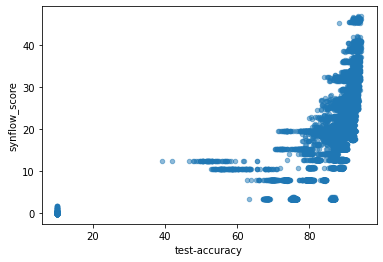

In [32]:
import pandas as pd
import matplotlib

accuracy = pd.read_csv('/content/drive/MyDrive/RisultatiNASWOT/Cifar10Accuracy200.csv', header=0)
accuracy['synflow_score'] = slog
accuracy

accuracy.plot.scatter(x="test-accuracy", y="synflow_score", alpha=0.5)
print(accuracy.corr('spearman'))




# Define Voting Score ☑
---
This score is produced by majority vote between Jacobian Gradient Norm (Mellor Paper) and Synflow score

In [ ]:
# Calculated Voting Score (to finish)

t=None
all_ds = {}
all_acc = {}
allc = {}
all_metrics = {}
all_runs = {}
metric_names = ['grad_norm', 'snip', 'grasp', 'fisher', 'synflow', 'jacob_cov']
for fname,rname in [('../results_release/nasbench2/nb2_cf10_seed42_dlrandom_dlinfo1_initwnone_initbnone.p','CIFAR10'),
                    ('../results_release/nasbench2/nb2_cf100_seed42_dlrandom_dlinfo1_initwnone_initbnone.p','CIFAR100'),
                    ('../results_release/nasbench2/nb2_im120_seed42_dlrandom_dlinfo1_initwnone_initbnone.p','ImageNet16-120')]:
    runs=[]
    f = open(fname,'rb')
    while(1):
        try:
            runs.append(pickle.load(f))
        except EOFError:
            break
    f.close()
    print(fname, len(runs))
    
    all_runs[fname]=runs
    all_ds[fname] = {}
    metrics={}
    for k in metric_names:
        metrics[k] = []
    acc = []
    
    if t is None:
        hl=['Dataset']
        hl.extend(metric_names)
        t = PrettyTable(hl)
    
    for r in runs:
        for k,v in r['logmeasures'].items():
            if k in metrics:
                metrics[k].append(v)
        acc.append(r['testacc'])
    
    all_ds[fname]['metrics'] = metrics
    all_ds[fname]['acc'] = acc
        
    res = []
    crs = {}
    for k in hl:
        if k=='Dataset':
            continue
        v = metrics[k]
        cr = abs(stats.spearmanr(acc,v,nan_policy='omit').correlation)
        #print(f'{k} = {cr}')
        res.append(round(cr,3))
        crs[k]=cr
    
    ds = rname
    all_acc[ds]=acc
    allc[ds]=crs
    t.add_row([ds]+res)
    
    all_metrics[ds] = metrics
print(t)

In [ ]:
from tqdm import tqdm
votes = {}
def vote(mets, gt):
    numpos = 0
    for m in mets:
        numpos += 1 if m > 0 else 0
    if numpos >= len(mets)/2:
        sign = +1
    else:
        sign = -1
    return sign*gt

for ds in all_acc.keys():
    num_pts = 15625
    #num_pts = 1000
    tot=0
    right=0
    for i in tqdm(range(num_pts)):
        for j in range(num_pts):
            if i!=j:
                diff = all_acc[ds][i] - all_acc[ds][j]
                if diff == 0:
                    continue
                diffsyn = []
                for m in ['synflow', 'jacob_cov', 'snip']:
                    diffsyn.append(all_metrics[ds][m][i] - all_metrics[ds][m][j])
                same_sign = vote(diffsyn, diff)
                right += 1 if same_sign > 0 else 0
                tot += 1
    votes[ds.lower() if 'CIFAR' in ds else ds] = right/tot
print('votes correlation: ', votes)

# Aging Evolution Algorithm (Synflow Proxy) 👾

---

### Algorithm Steps

1. Get N Random Architectures Called Population
2. Run Scoring Algorithm Based On Synflow Proxy Score
3. Choose the best architecture and mutate in order to generate a new one
4. Pop off the oldest architecture
5. Repeat for N Evolution Stage

In [ ]:
#@title ##Synflow Proxy Configuration { run: "auto" }
#configuration by param
n_trial =  10#@param {type:"integer"}
save_path = 'NASWOT_AgingEvolution_ReLu'#@param {type:"string"}
max_trained_models=1000 #@param {type: 'integer'}
pool_size=64 #@param {type: 'integer'}
tournament_size=20 #@param {type: 'integer'} 
preload_score = True #@param{type:"boolean"}


proxy_type = 'ReLu'

In [ ]:
# Get Synflow NasBench201 Score

import pickle

synflow_proxy=[]

file_path = ''
# dataset = config['dataset']
dataset = 'cifar100'
print(f'Dataset: {dataset}')
if dataset == 'cifar10':
  file_path = '/content/drive/MyDrive/results_release/nasbench2/nb2_cf10_seed42_dlrandom_dlinfo1_initwnone_initbnone.p'
elif dataset == 'cifar100':
  file_path = '/content/drive/MyDrive/results_release/nasbench2/nb2_cf100_seed42_dlrandom_dlinfo1_initwnone_initbnone.p'
else:
  file_path = '/content/drive/MyDrive/results_release/nasbench2/nb2_im120_seed42_dlrandom_dlinfo1_initwnone_initbnone.p'

f = open(file_path,'rb')
while(1):
    try:
        d = pickle.load(f)
        synflow_proxy.append(d['logmeasures']['synflow'])
    except EOFError:
        break
f.close()


Dataset: cifar100


In [ ]:
import pandas as pd

# dataset = config['dataset']


if dataset == 'cifar10':
  df = pd.read_csv('/content/NAS_MachineLearningDeepLearning/Cifar10Result.csv')
elif dataset == 'cifar100':
  df = pd.read_csv('/content/NAS_MachineLearningDeepLearning/Cifar100Result.csv')
else:
  df = pd.read_csv('/content/NAS_MachineLearningDeepLearning/ImageNet16Result.csv')

try: 
  df.drop(columns=['Unnamed: 0'], inplace=True)
except:
  print("Already dropped")

acc_df = df

In [ ]:
import pandas as pd

if dataset == 'cifar10':
  df = pd.read_csv('/content/drive/MyDrive/RisultatiNASWOT/Cifar10_CompleteRun.csv')
elif dataset == 'cifar100':
  df = pd.read_csv('/content/drive/MyDrive/RisultatiNASWOT/Cifar100_CompleteRun.csv')
else:
  df = pd.read_csv('/content/drive/MyDrive/RisultatiNASWOT/ImageNet_CompleteRun.csv')

try: 
  df.drop(columns=['Unnamed: 0'], inplace=True)
except:
  print("Already dropped")

naswot_score = df

In [ ]:
# Load Coded Architectures structures

_opname_to_index = {
    'none': 0,
    'skip_connect': 1,
    'nor_conv_1x1': 2,
    'nor_conv_3x3': 3,
    'avg_pool_3x3': 4
}

def get_spec_from_arch_str(arch_str):
    nodes = arch_str.split('+')
    nodes = [node[1:-1].split('|') for node in nodes]
    nodes = [[op_and_input.split('~')[0]  for op_and_input in node] for node in nodes]

    spec = [_opname_to_index[op] for node in nodes for op in node]
    return spec

idx_to_spec = {}
for i in range(0, max_uid):
    idx_to_spec[i] = get_spec_from_arch_str(searchspace.iloc[i]['arch_str'])

spec_to_idx = {}
for idx,spec in idx_to_spec.items():
    spec_to_idx[str(spec)] = idx

In [ ]:
import random
import copy
from ZeroCostNas.foresight.models import *
from ZeroCostNas.foresight.pruners import *
from ZeroCostNas.foresight.dataset import *
from ZeroCostNas.foresight.weight_initializers import init_net

dataset = config['dataset']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_num_classes(dataset):
    return 100 if dataset == 'cifar100' else 10 if dataset == 'cifar10' else 120

def get_synflow_score(uid):
  if proxy_type == 'ReLu':
    return naswot_score.iloc[uid]['score']
  if preload_score:
    return synflow_proxy[uid]
  else:
    net_config: pd.DataFrame = searchspace.loc[searchspace['uid'] == uid]
    net_config: dict = get_standard_config(net_config)
    network =  nasbench2.get_model_from_arch_str(net_config['arch_str'], get_num_classes(dataset))
    network.to(device)
    init_net(network, 'none', 'none')
    measures = predictive.find_measures(network, train_dt, ('random', 1, get_num_classes(dataset)), device)
    return measures['synflow']

def get_voting_score(uid):
  return vote_score[uid]

def random_spec():
    return random.choice(list(idx_to_spec.values()))

def mutate_spec(old_spec):

    possible_specs = []
    for idx_to_change in range(len(old_spec)): 
        entry_to_change = old_spec[idx_to_change]
        possible_entries = [x for x in range(5) if x != entry_to_change]
        for new_entry in possible_entries:
            new_spec = copy.copy(old_spec)
            new_spec[idx_to_change] = new_entry
            possible_specs.append((get_synflow_score(spec_to_idx[str(new_spec)]), new_spec))
    best_new_spec = random.choice(possible_specs)[1] # sorted(possible_specs, key=lambda i:i[0])[-1][1]
    return best_new_spec

def random_combination(pool, sample_size):
    indices = sorted(random.sample(range(len(pool)), sample_size))
    return pool.iloc[indices]

In [ ]:
def run_aging_evolution(max_trained_models, tournament_size, pool):
  epochs = 0
  best = {'arch': '', 'score': 0, 'acc': 0}
  history = {'UID': [-1],
           'Score': [0],
           'ValidationAccuracy': [0],
           'ArchitectureEncoded': [[1]]}
  history = pd.DataFrame(history)
  while epochs < max_trained_models:
    sample = random_combination(pool, tournament_size)
    # print('SAMPLE', tabulate(sample, headers='keys', tablefmt='psql', showindex=False))
    sample.sort_values(by='score', ascending=False, inplace=True)
    old_best = sample.head(1)
    new_spec = mutate_spec(old_best.iloc[0]['arch'])
    uid = spec_to_idx[str(new_spec)]

    score = get_synflow_score(uid) if score_type != 'vote' else get_voting_score(uid)
    acc = acc_df['valid-accuracy'].iloc[uid]

    history = history.append({
        'UID': uid,
        'ArchitectureEncoded': new_spec,
        'Score': score,
        'ValidationAccuracy': acc
    }, ignore_index=True)

    # Add New Spec 
    pool = pool.append({
        'uid': uid,
        'arch': new_spec,
        'score': score,
        'acc': acc
    }, ignore_index=True)
    
    # Kill Oldest Spec
    pool.drop(index=pool.index[0], 
        axis=0, 
        inplace=True)

    epochs += 1
  
  return pool, history

In [ ]:
import pandas as pd

def init_population(pool_size):
  pool = {'uid': [], 'arch': [], 'score': [], 'acc': []}
  for i in range(pool_size):
    arch = random_spec()
    uid = spec_to_idx[str(arch)]
    score = get_synflow_score(uid)
    acc = acc_df['valid-accuracy'].iloc[uid]
    pool['uid'].append(uid)
    pool['arch'].append(arch)
    pool['score'].append(score)
    pool['acc'].append(acc)
  return pd.DataFrame(pool)

In [ ]:
pool = init_population(pool_size)
pool

In [ ]:
# Aging Evolution Algorithm
import random
import pandas as pd
from tabulate import tabulate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = 'ImageNet16' # config['dataset']
trial = n_trial

start = time.time()

print('*******************************')
print('Running Aging Evolution algorithm')
print('Parameters:')
print(f'Dataset: {dataset}')
print(f'Num Round: {trial}')
print(f'Max Trained Models: {max_trained_models}')
print(f'Pool Size: {pool_size}')
print(f'Tournament Size: {tournament_size}')
print(f'Proxy Type: {proxy_type}')
print('*******************************')

results = {'UID': [],
           'Score': [],
           'ValidationAccuracy': [],
           'ArchitectureEncoded': [],
           'RunID': []}

# Init Population
for i in range(trial):
  pool = init_population(pool_size)

  models, history = run_aging_evolution(max_trained_models=max_trained_models, tournament_size=tournament_size, pool=pool)

  history.to_csv(f'/content/drive/MyDrive/RisultatiNASWOT/ImageNet16/{save_path}_{dataset}_RunHistory_RunID_{i}.csv')
  history.sort_values(by='Score', ascending=False, inplace=True)
  
  best = history.head(1)

  
  print(best)
  results['UID'].append(best.iloc[0]['UID'])
  results['Score'].append(best.iloc[0]['Score'])
  results['ValidationAccuracy'].append(best.iloc[0]['ValidationAccuracy'])
  results['ArchitectureEncoded'].append(best.iloc[0]['ArchitectureEncoded'])
  results['RunID'].append(i)

  print(f'Best Architecture Run {i}')
  print(tabulate(best, headers='keys', tablefmt='psql', showindex=False))


stop = time.time()
elapsed = stop-start

print(f'Total time {elapsed}')
results = pd.DataFrame(results)
results.to_csv(f'/content/drive/MyDrive/RisultatiNASWOT/ImageNet16/{save_path}_{dataset}.csv')


In [ ]:
import pandas as pd
res = {
    'uid': [],
    'score': [],
    'synflow_score': [],
    'accuracy': []
}

df = pd.read_csv('/content/drive/MyDrive/RisultatiNASWOT/Cifar100_CompleteRun.csv', header=0)

for i in range(len(df)):
  res['uid'].append(i)
  res['score'].append(df.iloc[i]['score'])
  res['synflow_score'].append(synflow_proxy[i])
  res['accuracy'].append(df.iloc[i]['accuracy'])

df = pd.DataFrame(res)
df.to_csv('/content/drive/MyDrive/RisultatiNASWOT/Cifar100_CompleteRun.csv')

# Regularized Evolution Algorithm (Synflow Proxy) 👾

---

### Algorithm Steps

1. Get N Random Architectures Called Population
2. Run Scoring Algorithm Based On Synflow Proxy Score
3. Choose the best architecture and mutate in order to generate a new one
4. Pop off the oldest architecture
5. Repeat for N Evolution Stage

In [132]:
#@title ##Synflow Proxy Configuration { run: "auto" }
#configuration by param
n_trial =  10#@param {type:"integer"}
save_path = 'NASWOT_AgingEvolution_ReLu'#@param {type:"string"}
max_trained_models=1000 #@param {type: 'integer'}
pool_size=64 #@param {type: 'integer'}
tournament_size=20 #@param {type: 'integer'} 
preload_score = True #@param{type:"boolean"}


proxy_type = 'SynFlow'

In [151]:
# Get Synflow NasBench201 Score

import pickle

synflow_proxy=[]

file_path = ''
# dataset = config['dataset']
dataset = 'ImageNet16'
print(f'Dataset: {dataset}')
if dataset == 'cifar10':
  file_path = '/content/drive/MyDrive/results_release/nasbench2/nb2_cf10_seed42_dlrandom_dlinfo1_initwnone_initbnone.p'
elif dataset == 'cifar100':
  file_path = '/content/drive/MyDrive/results_release/nasbench2/nb2_cf100_seed42_dlrandom_dlinfo1_initwnone_initbnone.p'
else:
  file_path = '/content/drive/MyDrive/results_release/nasbench2/nb2_im120_seed42_dlrandom_dlinfo1_initwnone_initbnone.p'

f = open(file_path,'rb')
while(1):
    try:
        d = pickle.load(f)
        synflow_proxy.append(d['logmeasures']['synflow'])
    except EOFError:
        break
f.close()


Dataset: ImageNet16


In [152]:
import pandas as pd

# dataset = config['dataset']

# accuracy = pd.read_csv('/content/drive/MyDrive/RisultatiNASWOT/Cifar10Accuracy200.csv', header=0)
if dataset == 'cifar10':
  df = pd.read_csv('/content/drive/MyDrive/RisultatiNASWOT/Cifar10Accuracy200.csv', header=0) # pd.read_csv('/content/NAS_MachineLearningDeepLearning/doc/Cifar10Result.csv')
elif dataset == 'cifar100':
  df = pd.read_csv('/content/drive/MyDrive/RisultatiNASWOT/Cifar100Accuracy200.csv', header=0) # pd.read_csv('/content/NAS_MachineLearningDeepLearning/doc/Cifar100Result.csv')
else:
  df = pd.read_csv('/content/drive/MyDrive/RisultatiNASWOT/ImageNet16Accuracy200.csv', header=0) # pd.read_csv('/content/NAS_MachineLearningDeepLearning/doc/ImageNet16Result.csv')

try: 
  df.drop(columns=['Unnamed: 0'], inplace=True)
except:
  print("Already dropped")

acc_df = df['test-accuracy'] if dataset == 'cifar10' else df['valid-accuracy']
# acc_df['valid-accuracy'] = df['test-accuracy'] if dataset == 'cifar10' else df['valid-accuracy']

In [153]:
acc_df[0]

27.36666668701172

In [154]:
import pandas as pd

if dataset == 'cifar10':
  df = pd.read_csv('/content/drive/MyDrive/RisultatiNASWOT/Cifar10_CompleteRun.csv')
elif dataset == 'cifar100':
  df = pd.read_csv('/content/drive/MyDrive/RisultatiNASWOT/Cifar100_CompleteRun.csv')
else:
  df = pd.read_csv('/content/drive/MyDrive/RisultatiNASWOT/ImageNet_CompleteRun.csv')

try: 
  df.drop(columns=['Unnamed: 0'], inplace=True)
except:
  print("Already dropped")

naswot_score = df

In [155]:
# Load Coded Architectures structures

_opname_to_index = {
    'none': 0,
    'skip_connect': 1,
    'nor_conv_1x1': 2,
    'nor_conv_3x3': 3,
    'avg_pool_3x3': 4
}

def get_spec_from_arch_str(arch_str):
    nodes = arch_str.split('+')
    nodes = [node[1:-1].split('|') for node in nodes]
    nodes = [[op_and_input.split('~')[0]  for op_and_input in node] for node in nodes]

    spec = [_opname_to_index[op] for node in nodes for op in node]
    return spec

idx_to_spec = {}
for i in range(0, max_uid):
    idx_to_spec[i] = get_spec_from_arch_str(searchspace.iloc[i]['arch_str'])

spec_to_idx = {}
for idx,spec in idx_to_spec.items():
    spec_to_idx[str(spec)] = idx

In [156]:
import random
import copy
from ZeroCostNas.foresight.models import *
from ZeroCostNas.foresight.pruners import *
from ZeroCostNas.foresight.dataset import *
from ZeroCostNas.foresight.weight_initializers import init_net

# dataset = config['dataset']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_num_classes(dataset):
    return 100 if dataset == 'cifar100' else 10 if dataset == 'cifar10' else 120

def get_synflow_score(uid):
  if proxy_type == 'ReLU':
    return naswot_score.iloc[uid]['score']
  if preload_score:
    return synflow_proxy[uid]
  else:
    net_config: pd.DataFrame = searchspace.loc[searchspace['uid'] == uid]
    net_config: dict = get_standard_config(net_config)
    network =  nasbench2.get_model_from_arch_str(net_config['arch_str'], get_num_classes(dataset))
    network.to(device)
    init_net(network, 'none', 'none')
    measures = predictive.find_measures(network, train_dt, ('random', 1, get_num_classes(dataset)), device)
    return measures['synflow']

def get_voting_score(uid):
  return vote_score[uid]

def random_spec():
    return random.choice(list(idx_to_spec.values()))

def mutate_spec(old_spec):

    possible_specs = []
    for idx_to_change in range(len(old_spec)): 
        entry_to_change = old_spec[idx_to_change]
        possible_entries = [x for x in range(5) if x != entry_to_change]
        for new_entry in possible_entries:
            new_spec = copy.copy(old_spec)
            new_spec[idx_to_change] = new_entry
            possible_specs.append((get_synflow_score(spec_to_idx[str(new_spec)]), new_spec))
    best_new_spec = random.choice(possible_specs)[1] # sorted(possible_specs, key=lambda i:i[0])[-1][1]
    return best_new_spec

def random_combination(pool, sample_size):
    indices = sorted(random.sample(range(len(pool)), sample_size))
    return pool.iloc[indices]

In [157]:
def run_aging_evolution(cycle, sample_size, pool, history):
  epochs = 0
  best = {'arch': '', 'score': 0, 'acc': 0}
  # history = {'UID': [-1],
  #          'Score': [0],
  #          'ValidationAccuracy': [0],
  #          'ArchitectureEncoded': [[1]]}
  # history = pd.DataFrame(history)
  while epochs < cycle:
    sample = random_combination(pool, sample_size)
    # print('SAMPLE', tabulate(sample, headers='keys', tablefmt='psql', showindex=False))
    sample.sort_values(by='score', ascending=False, inplace=True)
    parent = sample.head(1)
    new_spec = mutate_spec(parent.iloc[0]['arch'])
    uid = spec_to_idx[str(new_spec)]

    score = get_synflow_score(uid)# if score_type != 'vote' else get_voting_score(uid)
    acc = acc_df[uid]#acc_df['valid-accuracy'].iloc[uid]

    history = history.append({
        'uid': uid,
        'arch': new_spec,
        'score': score,
        'acc': acc
    }, ignore_index=True)

    # Add New Spec 
    pool = pool.append({
        'uid': uid,
        'arch': new_spec,
        'score': score,
        'acc': acc
    }, ignore_index=True)
    
    # Kill Oldest Spec
    pool.drop(index=pool.index[0], 
        axis=0, 
        inplace=True)

    epochs += 1
  
  return pool, history

In [158]:
import pandas as pd

def init_population(pool_size = 1000):
  pool = {'uid': [], 'arch': [], 'score': [], 'acc': []}
  history = {'uid': [], 'arch': [], 'score': [], 'acc': []}
  for i in range(pool_size):
    arch = random_spec()
    uid = spec_to_idx[str(arch)]
    score = get_synflow_score(uid)
    acc = acc_df[uid]# acc_df['valid-accuracy'].iloc[uid]
    pool['uid'].append(uid)
    pool['arch'].append(arch)
    pool['score'].append(score)
    pool['acc'].append(acc)

    history['uid'].append(uid)
    history['arch'].append(arch)
    history['score'].append(score)
    history['acc'].append(acc)
  return pd.DataFrame(pool), pd.DataFrame(history)

In [ ]:
# Aging Evolution Algorithm
import random
import pandas as pd
from tabulate import tabulate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = 'ImageNet16' # config['dataset']
trial = n_trial
pool_size = 1000
start = time.time()

print('*******************************')
print('Running Aging Evolution algorithm')
print('Parameters:')
print(f'Dataset: {dataset}')
print(f'Num Round: {trial}')
print(f'Max Trained Models: {max_trained_models}')
print(f'Pool Size: {pool_size}')
print(f'Tournament Size: {tournament_size}')
print(f'Proxy Type: {proxy_type}')
print('*******************************')

results = {'UID': [],
           'Score': [],
           'ValidationAccuracy': [],
           'ArchitectureEncoded': [],
           'RunID': []}

# Init Population
for i in range(50):#range(trial):
  pool, history = init_population(pool_size)

  models, history = run_aging_evolution(cycle=30, sample_size=64, pool=pool, history=history)

  # history.to_csv(f'{dataset}_RunHistory_RunID_{i}.csv')
  history.sort_values(by='score', ascending=False, inplace=True)
  
  best = history.head(1)

  
  print(best)
  results['UID'].append(best.iloc[0]['uid'])
  results['Score'].append(best.iloc[0]['score'])
  results['ValidationAccuracy'].append(best.iloc[0]['acc'])
  results['ArchitectureEncoded'].append(best.iloc[0]['arch'])
  results['RunID'].append(i)

  print(f'Best Architecture Run {i}')
  print(tabulate(best, headers='keys', tablefmt='psql', showindex=False))


stop = time.time()
elapsed = stop-start

print(f'Total time {elapsed}')
results = pd.DataFrame(results)
results.to_csv(f'{dataset}.csv')


In [ ]:
import pandas as pd
res = {
    'uid': [],
    'score': [],
    'synflow_score': [],
    'accuracy': []
}

df = pd.read_csv('/content/drive/MyDrive/RisultatiNASWOT/Cifar100_CompleteRun.csv', header=0)

for i in range(len(df)):
  res['uid'].append(i)
  res['score'].append(df.iloc[i]['score'])
  res['synflow_score'].append(synflow_proxy[i])
  res['accuracy'].append(df.iloc[i]['accuracy'])

df = pd.DataFrame(res)
df.to_csv('/content/drive/MyDrive/RisultatiNASWOT/Cifar100_CompleteRun.csv')

# Results Analysis 📊

In [177]:
cifar10_synflow_200_path = '/content/drive/MyDrive/project/results/cifar10_SynFlow_Accuracy200.csv'
cifar10_relu_200_path = '/content/drive/MyDrive/project/results/cifar10_ReLU_Accuracy200.csv'
cifar100_synflow_200_path = '/content/drive/MyDrive/project/results/cifar100_SynFlow_Accuracy200.csv'
cifar100_relu_200_path = '/content/drive/MyDrive/project/results/cifar100_ReLU_Accuracy200.csv'
imagenet_synflow_200_path = '/content/drive/MyDrive/project/results/ImageNet16_Synflow_Accuracy200.csv'
imagenet_relu_200_path = '/content/drive/MyDrive/project/results/ImageNet16_ReLU_Accuracy200.csv'

In [178]:
cifar10 = pd.read_csv(cifar10_synflow_200_path)
cifar100 = pd.read_csv(cifar100_synflow_200_path)
imagenet = pd.read_csv(imagenet_synflow_200_path)

cifar10_relu = pd.read_csv(cifar10_relu_200_path)
cifar100_relu = pd.read_csv(cifar100_relu_200_path)
imagenet_relu = pd.read_csv(imagenet_relu_200_path)

cifar10_accuracy = cifar10['ValidationAccuracy'].to_numpy()
cifar100_accuracy = cifar100['ValidationAccuracy'].to_numpy()
imagenet_accuracy = imagenet['ValidationAccuracy'].to_numpy()

cifar10_accuracy_relu = cifar10_relu['ValidationAccuracy'].to_numpy()
cifar100_accuracy_relu = cifar100_relu['ValidationAccuracy'].to_numpy()
imagenet_accuracy_relu = imagenet_relu['ValidationAccuracy'].to_numpy()

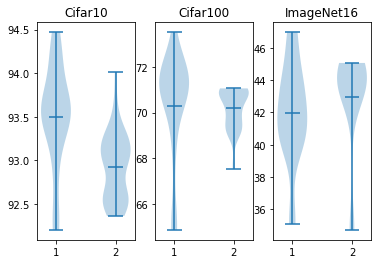

In [180]:
import matplotlib.pyplot as plt
import numpy as np

# data_to_plot = [cifar10_accuracy, cifar100_accuracy, imagenet_accuracy]

# fig = plt.figure()

# ax = fig.add_axes([0,0,1,1])
# ax.set_xticklabels(['Cifar10', 'Cifar100', 'ImageNet16'])
# bp = ax.violinplot(data_to_plot, showmeans=True)
# plt.show()


fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

# Plot violin plot on axes 1
ax1.violinplot([cifar10_accuracy, cifar10_accuracy_relu], showmeans=True,showextrema=True, showmedians=False)
ax1.set_title('Cifar10')

# Plot violin plot on axes 2
ax2.violinplot([cifar100_accuracy, cifar100_accuracy_relu], showmeans=True, showextrema=True,showmedians=False)
ax2.set_title('Cifar100')

# Plot violin plot on axes 3
ax3.violinplot([imagenet_accuracy, imagenet_accuracy_relu], showmeans=True,showextrema=True,showmedians=False)
ax3.set_title('ImageNet16')

plt.show()